The goal here is to modify the notebook that calculates and plots the TRMM clusters to work on <b> CMIP6 </b> model output. 

Import modules


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
from matplotlib.ticker import MaxNLocator,FormatStrFormatter
import pickle
from glob import glob
import sys  
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta
import itertools
import pickle
from cartopy.util import add_cyclic_point


from scipy.ndimage import label,find_objects
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap

import datetime as dt
### Hack to import basemap. Comment if not using basemap ###
# import os
# import conda

# conda_file_dir = conda.__file__
# conda_dir = conda_file_dir.split('lib')[0]
# proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
# os.environ["PROJ_LIB"] = proj_lib

# from mpl_toolkits import basemap

### If not using basemap, use cartopy ##
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import pandas as pd



%matplotlib inline

### Try using dask 

In [76]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1)
client

/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34313 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:41363 Dashboard: http://127.0.0.1:34313/status,Cluster Workers: 4 Cores: 4 Memory: 387.99 GB


CMIP6 stands for Coupled Model Intercomparison Project 6, : <a href="https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6">https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6</a>.
The algorithm in this notebook is roughly as follows:
<ol>
    <li> Create a list of CMIP6 files to read with specified start and end dates. Each file contains one month of data. </li>
    <li> Visualize the precipitation field, and the corresponding clusters for a specific time step. You can play around with this to develop a physical intuition for clusters </li>
    <li> Create clusters and construct probability density functions (pdfs) for cluster size and cluster power. The data can be saved to file to avoid re-running time consuming computation. </li>
    <li> Plot the pdfs for different time periods. You can play around to see how the pdfs vary with time length and period. Also include information about the cutoff in the plots. </li>
</ol>


<b>EDIT:</b> a few changes have been made to the previous version of this notebook:
<ol>
    <li> We now use the xarray package to read and slice input files</li>
    <li> We can now set the starting and ending dates for extraction, so you can use the same time period across models </li>
    <li> We now read both historical and SSP runs in the same notebook </li>
</ol>

<b> <font color=blue>EDITS (08/09/20)</font>:</b>
<ol>
    <li> We can now skip the visualization of precip. maps. Clicking on a link now directly takes you the cluster pdf computation part of the code.</li>
    <li> We now save the grid size information in the .out files, so they don't have to be read in separately when comparing historical to SSP. </li>
</ol>

### 1. Create a list of CMIP6 files to read with specified start and end dates. <br> Each file contains one month of data.


### First set the type of forcing ('HIST' or 'SSP')

In [77]:
forcing='HIST'
# forcing='SSP'
forcing='obs'

## small snippet to extract model names from the scratch directory ##
if forcing=='HIST':
    diri='/scratch/neelin/CMIP6/'
elif forcing=='SSP':
    diri='/scratch/neelin/CMIP6-SSP585/'
    
    
pr_dir='pr'
pr_ext='3hr'
pr_ext=''
# pr_ext='E1hr'
# pr_ext='6hrPlev' ## for NorESM2-MM



list_temp=(glob(diri+'*'))
model_list=[]
model_dir=[]

if forcing!='obs':

    for name in list_temp:
        temp_name=name.split('/')[-1]
        model_list.append(temp_name)
        model_dir.append(diri+temp_name+'/'+pr_dir+'/pr_'+pr_ext+'*')

    model_list=model_list[1:] ### neglect the first name, since it is not really a model
    model_dir=model_dir[1:] ### neglect the first name, since it is not really a model
    print(model_list)
    model_index=model_list.index('CNRM-CM6-1') ## find index of any model you want    

    
elif forcing=='obs':
    model_dir.append('/scratch/neelin/TRMM_3B42/*')
    model_index=0

### check the list of files in the model directory to see what the ```pr_ext``` variable should be ##

### Read files and extract subsets in time and latitude

In [78]:
model_files=glob(model_dir[model_index])
# model_files

In [21]:
xr.open_dataset(model_files[0])

<xarray.Dataset>
Dimensions:          (latitude: 280, longitude: 1440, time: 124)
Coordinates:
  * time             (time) datetime64[ns] 1998-02-01 ... 1998-02-06T03:00:00
  * latitude         (latitude) float32 -34.875 -34.625 ... 34.625 34.875
  * longitude        (longitude) float32 0.125 0.375 0.625 ... 359.625 359.875
Data variables:
    precip_trmm      (time, latitude, longitude) float32 ...
    source_trmm      (time, latitude, longitude) float32 ...
    satobstime_trmm  (time, latitude, longitude) float32 ...

In [39]:
model_files=glob(model_dir[model_index])
### READ model file ###
PR_VAR='pr'
PRECIP_FACTOR=36e2 ## Factor to convert precip. units to mm/hr


if forcing=='obs':
    PR_VAR='precip_trmm'
    PRECIP_FACTOR=1.0
    
### Read all model files ###
pr_ds=xr.open_mfdataset(model_files)

### fix datetime format ##
def fix_datetime(ds):

    try:
        datetimeindex = ds.indexes['time'].to_datetimeindex()
        ds['time'] = datetimeindex
    except:
        pass

fix_datetime(pr_ds)

if forcing!='obs':
    ### changing the longitude values from -180 to 180 to avoid some plotting errors 
    pr_ds.coords['lon'] = (pr_ds.coords['lon'] + 180) % 360  - 180
    pr_ds = pr_ds.sortby(pr_ds.lon)

elif forcing=='obs':
    pr_ds=pr_ds.rename({'latitude':'lat','longitude':'lon'})
    
    

### Fixing the datetime: KACE ##

In [40]:
# yr,mo,day,hr=pr_ds.time[0].dt.year,pr_ds.time[0].dt.month,pr_ds.time[0].dt.day,pr_ds.time[0].dt.hour
# strt_date=dt.datetime(yr,mo,day,hr)
# pr_ds['time']=pd.date_range(strt_date,freq='3H',periods=pr_ds.time.size)

### Examine the data time range use it set time bounds for extraction##
The cell below gives starting and ending year and month

In [41]:
print(pr_ds.time[0].dt.year.values,pr_ds.time[0].dt.month.values)
print(pr_ds.time[-1].dt.year.values,pr_ds.time[-1].dt.month.values)

1998 2
2014 12


In [43]:
## Specify start and end dates to extract from
strt_date=dt.datetime(2098,1,1)
end_date=dt.datetime(2100,12,31)

strt_date=dt.datetime(2010,1,1)
end_date=dt.datetime(2012,12,31)

time_slice=slice(strt_date,end_date)
## Specify latitudinal bounds to extract
lat_slice=slice(-30,30)
pr_ds=pr_ds.sel(time=time_slice,lat=lat_slice) ## only extract specified timeslice

lon=pr_ds.lon
lat=pr_ds.lat

dates=pr_ds.time.dt.strftime('%Y-%M-%d %H')

### Declare useful constants related to grid sizes ###

In [44]:
Rearth=6.37e6  ## Earth's equatorial radius in meters

## get the grid sizes dx and dy in meters ###
nx =lon.size # no. of grid points
ny =lat.size  
dx=2.*np.pi*Rearth*(np.cos(np.pi*lat.values/180))/nx           #whole globe, periodic in x, dx in meters
dphi=np.gradient(lat.values)*np.pi/180  ## dphi in radians
dy=dphi*Rearth ## dy in meters

## for simplicity, we assume a single dx and dy for the domain. 
## Even though we should recognize that dx and dy vary with latitude.
precip_cluster_power_scale=2.5*dx.mean()*dy[0]*1e-6/3.6 ## cluster power in GW  ## Convert integrated precip. into power
pixels_to_area=dx.mean()*dy[0]*1e-6 ### factor convert the number of pixels to area in km^2

Read precip

In [46]:
prc=pr_ds[PR_VAR]*PRECIP_FACTOR

<b> Note: if the goal is to only look at the cluster pdfs, the next few cells can be skipped</b>. Click [here](#cell_cluster_pdfs) to go to the cluster pdf computation

### Read precip. values, and mask values below threshold ###

In [ ]:
prc_min_thresh=0.25 ## in mm/hr
prc_masked=prc.where(prc>=prc_min_thresh)

### 2. Visualize the precipitation field, and the corresponding clusters for a specific time step.

In [ ]:
### Create colorbar for precipitation ###

nws_precip_colors = [
#     "#04e9e7",  # 0.01 - 0.10 inches
#     "#019ff4",  # 0.10 - 0.25 inches
#     "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
#     "#f800fd",  # 6.00 - 8.00 inches
#     "#9854c6",  # 8.00 - 10.00 inches
#     "#fdfdfd"   # 10.00+
]
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)

levels=np.arange(0.0,5.25,.25)
levels_mean=np.arange(0.0,5.25,.25)*1e-1
norm = matplotlib.colors.BoundaryNorm(levels, precip_colormap.N)
norm_mean = matplotlib.colors.BoundaryNorm(levels_mean, precip_colormap.N) I

Pick a specific time step. Visualize the precipitation map, and the clusters that can be formed out this map. Change time step to get a feel for how the clusters are produced.

In [ ]:
pr_ds.time

In [ ]:
### Select time step here ##
### note that you have to specify hours too as T01-T23 or you get all the values in a given day ##
### just type pr_ds.time in a new cell to see the time format ###
# select_date='2099-04-01T21'
select_date='2013-04-01T19'
prc_inst=np.squeeze(prc_masked.sel(time=select_date).values)

First declare some values useful constants 

In [25]:
# prc_input=np.ma.masked_invalid(prc_inst)
prc_input=np.squeeze(pr_ds.sel(time=select_date).pr.values*PRECIP_FACTOR)
prc_input[prc_input<prc_min_thresh]=0.0
### Use pixel contiguity to identify clusters ##
labeled_prc, num_features = label(prc_input)
levels_labels=np.arange(0,num_features,1)
labels_masked=np.ma.masked_where(labeled_prc==0,labeled_prc)
cluster_power_masked=np.zeros_like(labels_masked)

pal=plt.get_cmap('YlGnBu')

label_objs=find_objects(labels_masked)

for j in np.arange(len(label_objs)):

    sl=label_objs[j]
    pcp_slice=prc_input[sl]
    label_slice=labels_masked[sl]
    cluster_power_masked[sl][pcp_slice>0]=pcp_slice.sum()*precip_cluster_power_scale


    
levels_pow=np.arange(2.0,7.25,.25)
norm_pow = matplotlib.colors.BoundaryNorm(levels_pow, precip_colormap.N)

NameError: name 'select_date' is not defined

### Plot mean precipitation for check ###values

In [ ]:
### Time mean here is not the mean over masked values ###
prc_mean=prc.mean(dim='time').values

In [ ]:
prc_mean.min()

In [ ]:
### Removing the central_longitude=180 will switch the plot center ##
fig,axx = plt.subplots(1,1,figsize=(12, 3),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}) 
ax=axx
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(prc_mean, 
             cmap=precip_colormap,
             interpolation='none',norm=norm_mean, 
             extent=[lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]],
             origin='lower',
             transform=ccrs.PlateCarree())


#get size and extent of axes:
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='mm/hr',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('Time mean %s precipitation from %s-%s'%(model_list[model_index],time_slice.start.strftime("%Y%m"),time_slice.stop.strftime("%Y%m")),fontsize=15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.tight_layout()

if forcing=='SSP':
    fname='Time_mean_precip_SSP585_%s'%(model_list[model_index])+'_'+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+'.pdf'
elif forcing=='HIST':
    fname='Time_mean_precip_%s'%(model_list[model_index])+'_'+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+'.pdf'
## stores in a local directory called plots ##
plt.savefig('./plots/'+fname,format='pdf',dpi=150,bbox_inches='tight')

### Plot selected timestep ###

In [ ]:
fig,axx = plt.subplots(2,1,figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)

ax=axx[0]
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180),figsize=(12,6))
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(prc_inst, 
             cmap=precip_colormap,
             interpolation='none',norm=norm, 
             extent=[lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]],
             origin='lower', 
             transform=ccrs.PlateCarree())
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='mm/hr',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

if forcing=='SSP':
    ax.set_title('%s SSP585 precipitation at %s'%(model_list[model_index],dates.sel(time=select_date).values),fontsize=15)
elif forcing=='HIST':
    ax.set_title('%s precipitation at %s'%(model_list[model_index],dates.sel(time=select_date).values),fontsize=15)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

ax=axx[1]
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(np.log10(cluster_power_masked),cmap=precip_colormap,interpolation='none',aspect='auto',
             origin='lower',norm=norm_pow,
             extent=[lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]],
             transform=ccrs.PlateCarree())

ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='Cluster Power (GW)',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('Precipitation Clusters',fontsize=15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.tight_layout()

if forcing=='SSP':
    fname='Instantaneous_precip_SSP585_%s_%s'%(model_list[model_index],select_date)+'.pdf'
elif forcing=='HIST':
    fname='Instantaneous_precip_%s_%s'%(model_list[model_index],select_date)+'.pdf'    
## stores in a local directory called plots ##
plt.savefig('./plots/'+fname,format='pdf',dpi=150,bbox_inches='tight')

<a id='cell_cluster_pdfs'></a>  

### Create cluster pdfs ###

Create bins to hold the cluster size and power pdfs

In [47]:
#### CLUSTER SIZE and POWER PDF bins ###
sizes=2**np.arange(0,18.25,.25)
sizes=np.unique(np.int_(sizes))-0.5

sz=(sizes[:-1]+sizes[1:])*0.5
sz_diff=np.diff(sizes)

pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)



Create a list of precip. thresholds

In [48]:
pthresh_list=[.25, .5, .75, 1.0]  ## list of precip. thresholds

Function to perform cluster analysis. Takes file name as input and yields outputs:
    <ol>
    <li> Counts of precip. cluster power</li>
    <li> Counts of precip. cluster size </li>
    <li> List of cluster power </li>
    <li> List of cluster size </li>
    </ol>

The counts will be use to create historgrams. The lists of cluster power and size will allow us to estimate measures like the moment ratio (which is a proxy for the exponential cutoff).


Unlike the TRMM precipitation, where we had one file per day, the CMIP6 precipitation is in one giant variable. So we will modify our strategy related to parallel computing. 

In [49]:
def perform_cluster_analysis_cmip6(prc):
        
    hist_pcp_sizes={}   
    hist_pcp_clust_pow={}
    pcp_sizes={}
    pcp_power={}
    
    for k in pthresh_list:
                
        arrp=np.copy(prc)
        arrp[prc>k]=1
        arrp[prc<=k]=0
        hist_pcp_sizes[k]=np.zeros_like(sz)    
        hist_pcp_clust_pow[k]=np.zeros_like(pcp_clust_sz)
        
        pcp_sizes[k]=np.zeros((1))
        pcp_power[k]=np.zeros((1))
        
        for ti in np.arange(prc.shape[0]):
            
            ### Cluster precipitation ###
        
            labeled_array_pcp, num_features_pcp = label(arrp[ti,:])
            ind=np.where(labeled_array_pcp[:,0]>0)[0]            
                
            ## Condition to take care of doubly periodic clusters ##

            # Assuming lat x lon array
            # Are there pixels along the longitude boundary whose label values are both > 0? 
            if any(np.logical_and(labeled_array_pcp[:,-1][ind]>0,labeled_array_pcp[:,0][ind]>0)):

                # If yes, then get their local addresses in the column        
                indy=np.where(np.logical_and(labeled_array_pcp[:,-1][ind]>0,labeled_array_pcp[:,0][ind]>0))
                # Loop through each address        
                for j in indy[0]:
                    # Get the destination label: of the last column
                    dest_label=labeled_array_pcp[:,-1][ind][j]
                    # Get the target label: of the first column
                    target_label=labeled_array_pcp[:,0][ind][j]
                    # Make all pixels with destination labels=target labels
                    labeled_array_pcp[labeled_array_pcp==dest_label]=target_label

                ## Update number of features
                num_features_pcp=np.unique(labeled_array_pcp[labeled_array_pcp>0]).size
                                        
            if num_features_pcp==0:
                mx,mn=1,0
            else:
                mx,mn=labeled_array_pcp.max(),1
                        
            ## Bin by cluster size ##

            hist_label=(ndimage.histogram(labeled_array_pcp,mn,mx,mx,labels=labeled_array_pcp))
            hist_pcp_sizes[k]+=np.histogram(hist_label,bins=sizes)[0]
            
            
###           snippet to determine timestep with largest clusters ###
#             if smax==0:
#                 smax=hist_label[hist_label>0].max()
#                 tmax=0
            
#             elif (hist_label[hist_label>0].max()>smax):
#                 smax=hist_label[hist_label>0].max()
#                 tmax=ti
            
            pcp_sizes[k]=np.append(pcp_sizes[k],hist_label[hist_label>0])
            label_objs=find_objects(labeled_array_pcp)
            pcp_cluster_pow=np.zeros(len(label_objs))
            pcp_cluster_sz=np.zeros(len(label_objs))
                        
            ## Compute and bin by cluster power
            ctr=0             
            for j in np.arange(len(label_objs)):

                sl=label_objs[j]
                arrp_slice=arrp[ti,:][sl]
                pcp_slice=prc[ti,:][sl]
                label_slice=labeled_array_pcp[sl]
                indj=np.where(label_slice==j+1)
                pcp_cluster_pow[j]=pcp_slice[indj].sum()*precip_cluster_power_scale
                pcp_cluster_sz[j]=pcp_slice[indj].size

            if (pcp_cluster_pow[pcp_cluster_pow>0].shape!=hist_label[hist_label>0].shape):
                print ('power, size:', pcp_cluster_pow[pcp_cluster_pow>0].shape,pcp_cluster_sz[pcp_cluster_sz>0].shape, 
                       hist_label[hist_label>0].shape)
                exit()

            pcp_power[k]=np.append(pcp_power[k],pcp_cluster_pow[pcp_cluster_pow>0])              
            hist_pcp_clust_pow[k]+=np.histogram(pcp_cluster_pow,bins=pcp_clus_pow_bins)[0]
            pcp_power[k]=pcp_power[k][1:]  ## neglect the first value, since it is zero
            pcp_sizes[k]=pcp_sizes[k][1:]
            
            
    return hist_pcp_clust_pow, hist_pcp_sizes, pcp_power, pcp_sizes 




We have a large number of files to work with. So to speed up the code, we will recruit multiple processors to work through the data. The jupyter machine has 160 processors, but we will recruit a fraction of this number to avoid clogging up the machine. To see how many processors are currently available, you can open a terminal and type `htop`.

<p>
We first define the number of desired processors that will work in parallel. Each processor will work with one subset of the precip. array at a time, which is the input to `perform_cluster_analysis`. The results from different processors are then pooled at the end. <br> <b> Note:</b> this step can be time consuming depending on number of files being processed.
</p>

In [50]:
prc_values=prc.values ### load the precip. values into memory; this step can be slightly time-consuming depending on array size

<a id='cell_multiprocess'></a>  

In [51]:
%%capture output 
from multiprocessing import Pool  ### module for parallel programming
import time as time_module ## module to time this cell
nproc=50

### first split the array into a list of sub-arrays
prc_subarray=np.array_split(prc_values,nproc,axis=0)  ## split precip. array along time axis ###
start_time=time_module.time()
pool = Pool(processes=nproc)
pooled_list = pool.map(perform_cluster_analysis_cmip6, prc_subarray) ### a list containing all the pooled results
print('Took %.2f minutes'%((time_module.time()-start_time)/60))

Organize the results from the cluster analysis, and save to file (optional).

In [53]:
### create dictionaries to collect and store output ###
### each dictionary has a key associated with the precip. threshold ###
hist_pcp_sizes={}   
hist_pcp_clust_pow={}
pcp_sizes={}
pcp_power={}

## Create empty lists to store the cluster counts (hist) and the collection of actual cluster metrics
for k in pthresh_list:
    hist_pcp_sizes[k]=[]   
    hist_pcp_clust_pow[k]=[]  
    pcp_sizes[k]=[]  
    pcp_power[k]=[]  

### Stack the pooled output from above into these lists
for i in range(len(pooled_list)):
    cluster_list=(pooled_list[i])
    for k in pthresh_list:
        hist_pcp_clust_pow[k].append(cluster_list[0][k])
        hist_pcp_sizes[k].append(cluster_list[1][k])
        pcp_power[k].append(cluster_list[2][k])
        pcp_sizes[k].append(cluster_list[3][k])

### Convert the lists into arrays ###
for k in pthresh_list:
    hist_pcp_clust_pow[k]=np.asarray(hist_pcp_clust_pow[k]).sum(0)  ### sum the counts across all files
    hist_pcp_sizes[k]=np.asarray(hist_pcp_sizes[k]).sum(0)  ### sum the counts across all files
    pcp_power[k]=np.hstack(pcp_power[k]) ## stack all the power measurements
    pcp_sizes[k]=np.hstack(pcp_sizes[k]) ## stack all the size measurements

###
SAVE=True
if SAVE:
    dir_save='./' ### change as per required destination, default is current working directory
    data={}
    data['hist_pcp_sizes']=hist_pcp_sizes
    data['hist_pcp_clust_pow']=hist_pcp_clust_pow
    data['pcp_sizes']=pcp_sizes
    data['pcp_power']=pcp_power
    data['sizes']=sizes
    data['precip_cluster_power_scale']=precip_cluster_power_scale
    data['pixels_to_area']=pixels_to_area
    if forcing=='SSP':
        save_file_name=dir_save+"clusters_output_SSP585_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"
    elif forcing=='HIST':
        save_file_name=dir_save+"clusters_output_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"
    elif forcing=='obs':
        save_file_name=dir_save+"clusters_output_%s"%('TRMM3B42')+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"


        
    with open(save_file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

 <b> Note: </b> if the file has been saved above, you do not have to re-run the cell [with multiprocessing](#cell_multiprocess) or the cell that [organizes the data](#cell_oragnize_data) when you restart the kernel.


Now open the saved file and create the cluster pdfs

In [54]:
ls ./*.out

./clusters_output_200801_200905.out
./clusters_output_BCC_3hr_201301_201412.out
./clusters_output_CESM.out
./clusters_output_CNRM-CM6-1_201001_201212.out
./clusters_output_CNRM-CM6-1-HR_201301_201412.out
./clusters_output_CNRM-CM6-1.out
./clusters_output_NASA-GISS.out
./clusters_output_SNU.SAM0-UNICON.out
./clusters_output_SSP585_@BCC-CSM2-MR_209801_210012.out
./clusters_output_SSP585_CNRM-CM6-1_209801_210012.out
./clusters_output_SSP585_CNRM-CM6-1-HR_209801_210012.out
./clusters_output_SSP585_CNRM-CM6-1.out
./clusters_output_SSP585_MIROC6_209801_210012.out
./clusters_output_SSP585_@NorESM2-MM_209801_210012.out
./clusters_output_TRMM3B42_200201_201501.out
./clusters_output_TRMM3B42_200801_200905.out
./clusters_output_TRMM3B42_201001_201212.out


In [79]:
### If reading an already saved file
READ=True
if READ:
    dir_save='./' ### change as per required destination, default is current working directory

    if forcing=='SSP':
        read_file_name=dir_save+"clusters_output_SSP585_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"
    elif forcing=='HIST':
        read_file_name=dir_save+"clusters_output_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"
    elif forcing=='obs':
        read_file_name=dir_save+"clusters_output_%s"%('TRMM3B42')+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"


    with open(read_file_name, 'rb') as handle:
        f = pickle.load(handle,encoding='bytes')
    hist_pcp_clust_pow=f['hist_pcp_clust_pow']
    hist_pcp_sizes=f['hist_pcp_sizes']
    pcp_sizes=f['pcp_sizes']
    pcp_power=f['pcp_power']


### 4. Plot the pdfs for different time periods. You can play around to see how the pdfs vary with time length and period. Also include information about the cutoff in the plots. 

In the plot below, we will present the following information:
<ol>
    <li> The cluster size and power pdfs on a log-log plot for the different rain thresholds. </li>
    <li> A straight line fit over the power law range (set by user), and the slope for one rain threshold case </li>
    <li> The moment ratio (second moment over first moment) for cluster size ($a_M$) and power ($c_M$). These quantiies can thought of as <b> proxies for where the exponential cutoff occur</b>.
</ol>

/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/env

[1.677756e+06 6.221900e+05 3.442430e+05 2.487100e+05 1.706900e+05
 2.334350e+05 8.284900e+04 1.248370e+05 9.127600e+04 9.923400e+04
 7.152600e+04 5.445700e+04 5.557900e+04 6.004400e+04 4.313700e+04
 3.795800e+04 3.217400e+04 3.294100e+04 2.606800e+04 2.244400e+04
 2.014500e+04 1.809300e+04 1.487800e+04 1.320200e+04 1.087900e+04
 9.193000e+03 7.464000e+03 6.121000e+03 4.743000e+03 3.610000e+03
 2.574000e+03 1.926000e+03 1.188000e+03 8.010000e+02 4.710000e+02
 2.650000e+02 1.360000e+02 6.100000e+01 4.100000e+01 1.600000e+01
 7.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00]


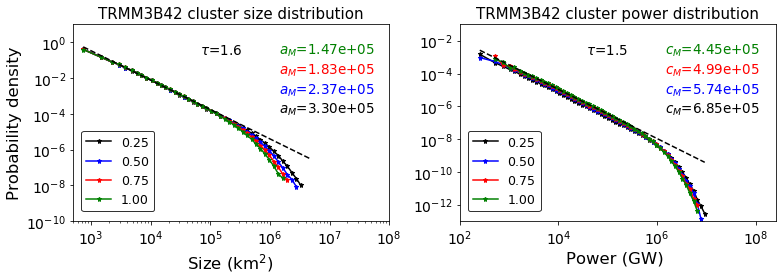

In [122]:
### Some user defined parameters ###
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=3.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=3.0,5.5 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[5e2,1e8] 
ylim_sz=[1e-10,1e1] ##

## x and yaxis limits for cluster power
xlim_pow=[1e2,2.5e8] ##
ylim_pow=[1e-13,1e-1] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

if forcing!='obs':
    TITLE=model_list[model_index]
else:
    TITLE='TRMM3B42'

### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

### set four colors here for the different precip. thresholds ###
c=['black','blue','red','green']

### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[.55, 0.65, .75, .85,.65, 0.725, .8, .875 ]
posx=[.65, .65, .65, 0.65, .35, .4, .4 ]
iendt=[5, 4.5, 4, 3.5, 3.0, 3.0, 3.0, 3.0]

### Loop through each value of the precip. threshold and  plot the cluster pdfs ###
for j,k in enumerate(pthresh_list):
    ax=ax1

    ### there are the start and end of the power law range: adjust according to eye ###
    istrt,iend=istrt_sz,iend_sz

    
    if (k in pthresh_list):  ### use this if you want to plot a smaller subset of rain thresholds
        nid= ([l for l,m in enumerate(pthresh_list) if m==k])
        nid=np.int(nid[0])

        ### create pdfs out of cluster histogram of counts
        hist_pcp_clust_size_pdf=hist_pcp_sizes[k]/(sz_diff*hist_pcp_sizes[k].sum())
        
        ### remove bins with less than nthresh counts ##
        hist_pcp_clust_size_pdf[hist_pcp_sizes[k]<nthresh]=np.nan
                
        ### plot the cluster size pdf on a log-log scale ##
        ln1[nid],=ax.loglog(sz*pixels_to_area,hist_pcp_clust_size_pdf,marker='*',c=c[nid],markersize=5)

    ### The straight line fit to the power law range ###
    ### select portions of the curve bounded by the power law range ###
    arrx,arry=np.log10(sz*pixels_to_area),np.log10(hist_pcp_sizes[k]/(sz_diff*hist_pcp_sizes[k].sum()))
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]
    
    ### perform a linear regression over this selected portion ###
    ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
    
    ### Use the slope and intercept from the linear regression to create the straight line ###
    pdf_pcp_sizes=((sz*pixels_to_area)**(ret[0]))*(10**(ret[1]))
    
    ## Remove portions of the straight line that extend too far beyond the cutoff
    pdf_pcp_sizes[sz*pixels_to_area>5e6]=np.nan 
    
    ### Now compute the moment ratio and print it in on plot ##
    if (k in pthresh_list):
        sm=np.mean(pcp_sizes[k]**2)*pixels_to_area/np.mean(pcp_sizes[k])
        ax.text(posx[j],posy[j],'$a_M$=%.2e'%(sm),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])
#         ax.text(posx[j],posy[j],'$\\tau_{lin}$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=11.5,color=c[nid])
#         ax.loglog(sz*pixels_to_area,pdf_pcp_sizes*1e0,linestyle='--',c=c[nid])
        

    if (j==len(pthresh_list)-1):

        ### Set plot title and axis labels
        ax.set_title("%s cluster size distribution"%(TITLE),
                     fontsize=title_fontsize)
        ax.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax.set_xlim(xlim_sz)
        ax.set_ylim(ylim_sz)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax.tick_params(which='both', labelsize=ticks_fontsize)
#         ax.text(0.001, 0.475,' Rain threshold\n (mm/hr)',transform=ax.transAxes,fontsize=leg_fontsize,fontweight='bold')
        ax.text(posx[j]-0.25,posy[j],'$\\tau$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=leg1_fontsize,color='black')
        ax.loglog(sz*pixels_to_area,pdf_pcp_sizes*1e0,linestyle='--',c='black')


        leg=ax.legend((ln1[0],ln1[1],ln1[2],ln1[3]), \
        ( "%.2f"%(pthresh_list[0]), "%.2f"%(pthresh_list[1]), "%.2f"%(pthresh_list[2]), "%.2f"%(pthresh_list[3]),
        ),fontsize=leg_fontsize, loc=(.025, .05),ncol=1 )
        ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')


    ax=ax2

    istrt,iend=istrt_pow,iend_pow 
    if (k in pthresh_list):
        hist_pcp_clust_pow_pdf=hist_pcp_clust_pow[k]/(pcp_clust_sz_diff*hist_pcp_clust_pow[k].sum())
        hist_pcp_clust_pow_pdf[hist_pcp_clust_pow_pdf==0]=np.nan
        ### remove bins with less than nthresh counts ##
#         print()
#         hist_pcp_clust_pow_pdf[hist_pcp_sizes[k]<nthresh]=np.nan


        
        ln2[nid],=ax.loglog(pcp_clust_sz,hist_pcp_clust_pow_pdf,marker='*',c=c[nid],markersize=5)




    arrx,arry=np.log10(pcp_clust_sz),np.log10(hist_pcp_clust_pow[k]/(pcp_clust_sz_diff*hist_pcp_clust_pow[k].sum()))
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<=iend)],arry[np.logical_and(arrx>istrt,arrx<=iend)]
    try:
        ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
        pdf_pcp_power=((pcp_clust_sz)**(ret[0]))*(10**(ret[1]))
        pdf_pcp_power[pcp_clust_sz>1e7]=np.nan
    except:
        ## if the power law range does not exist within the specified window,
        ## don't plot it 
        pdf_pcp_power=np.zeros_like(pcp_clust_sz)
        

    if (k in pthresh_list):
#         ax.loglog(pcp_clust_sz,pdf_pcp_power*1e0,linestyle='--',c=c[nid])
        sm=np.mean(pcp_power[k]**2)/np.mean(pcp_power[k])
        ax.text(posx[j],posy[j],'$c_M$=%.2e'%(sm),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])

    #         ax.text(posx[j],posy[j],'$\\tau_{lin}$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=11.5,color=c[nid])
#         ax.text(posx[j],posy[j],'$\\tau_{lin}$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=11.5,color=c[nid])
        ax.tick_params(which='both', labelsize=ticks_fontsize)

    if (j==len(pthresh_list)-1):

#         ax.text(0.001, 0.5,' Rain threshold\n (mm/hr)',transform=ax.transAxes,fontsize=9,fontweight='bold')
        leg=ax.legend((ln1[0],ln1[1],ln1[2],ln1[3]), \
        ( "%.2f"%(pthresh_list[0]), "%.2f"%(pthresh_list[1]), "%.2f"%(pthresh_list[2]), "%.2f"%(pthresh_list[3]),
        ),fontsize=leg_fontsize, loc=(.025, .05),ncol=1 )
        ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')
        ax.loglog(pcp_clust_sz,pdf_pcp_power*1e0,linestyle='--',c='black')
    
        ax.text(posx[j]-0.25,posy[j],'$\\tau$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=leg1_fontsize,color='black')
        ax.set_title("%s cluster power distribution"%(TITLE),fontsize=title_fontsize)
        ax.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax.set_xlim(xlim_pow)
        ax.set_ylim(ylim_pow)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))

plt.tight_layout()
plt.subplots_adjust(top=0.9)


SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    if forcing=='SSP':
        save_fig_name="./plots/"+"clusters_pdfs_SSP585_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"
    elif forcing=='HIST':
        save_fig_name="./plots/"+"clusters_pdfs_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"
    elif forcing=='obs':
        save_fig_name="./plots/"+"clusters_pdfs_%s"%('TRMM3B42')+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"


    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')




### Log linear ###

/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: divide by zero encountered in log10


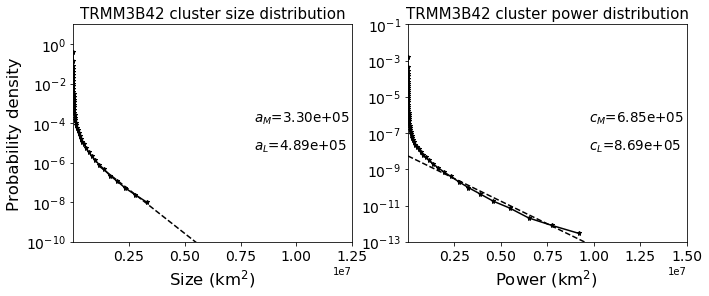

In [144]:
### Some user defined parameters ###
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=.1e7,0.45e7 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=0.125e7,1.2e7 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[5e2,1.25e7] 
ylim_sz=[1e-10,1e1] ##

## x and yaxis limits for cluster power
xlim_pow=[1e2,1.5e7] ##
ylim_pow=[1e-13,1e-1] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

if forcing!='obs':
    TITLE=model_list[model_index]
else:
    TITLE='TRMM3B42'

### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

### set four colors here for the different precip. thresholds ###
c=['black','blue','red','green']

### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[.55, 0.65, .75, .85,.65, 0.725, .8, .875 ]
posx=[.65, .65, .65, 0.65, .35, .4, .4 ]
iendt=[5, 4.5, 4, 3.5, 3.0, 3.0, 3.0, 3.0]

### Loop through each value of the precip. threshold and  plot the cluster pdfs ###
for j,k in enumerate(pthresh_list):
    ax=ax1

    ### there are the start and end of the power law range: adjust according to eye ###
    istrt,iend=istrt_sz,iend_sz
    
    if (k in pthresh_list[:1]):  ### use this if you want to plot a smaller subset of rain thresholds
        nid= ([l for l,m in enumerate(pthresh_list) if m==k])
        nid=np.int(nid[0])

        ### create pdfs out of cluster histogram of counts
        hist_pcp_clust_size_pdf=hist_pcp_sizes[k]/(sz_diff*hist_pcp_sizes[k].sum())
        
        ### remove bins with less than nthresh counts ##
        hist_pcp_clust_size_pdf[hist_pcp_sizes[k]<nthresh]=np.nan
                
        ### plot the cluster size pdf on a log-log scale ##
        ln1[nid],=ax.semilogy(sz*pixels_to_area,hist_pcp_clust_size_pdf,marker='*',c=c[nid],markersize=5)

    ### The straight line fit to the power law range ###
    ### select portions of the curve bounded by the power law range ###
    arrx,arry=(sz*pixels_to_area),np.log10(hist_pcp_sizes[k]/(sz_diff*hist_pcp_sizes[k].sum()))
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]
    
    ### perform a linear regression over this selected portion ###
    ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])    
    
#     ### Use the slope and intercept from the linear regression to create the straight line ###
    pdf_pcp_sizes=10**((sz*pixels_to_area)*ret[0]+ret[1])
    
#     ## Remove portions of the straight line that extend too far beyond the cutoff
    pdf_pcp_sizes[(sz*pixels_to_area)<istrt]=np.nan

    
    ### Now compute the moment ratio and print it in on plot ##
    if (k in pthresh_list[:1]):
        sm=np.mean(pcp_sizes[k]**2)*pixels_to_area/np.mean(pcp_sizes[k])
        sL=-1./(ret[0]*np.log(10))
        
        ax.text(posx[j],posy[j],'$a_M$=%.2e'%(sm),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])
        ax.text(posx[j],posy[j]-0.125,'$a_L$=%.2e'%(sL),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])

    if (j==0):

        ### Set plot title and axis labels
        ax.set_title("%s cluster size distribution"%(TITLE),fontsize=title_fontsize)
        ax.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax.set_xlim(xlim_sz)
        ax.set_ylim(ylim_sz)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax.tick_params(which='both', labelsize=ticks_fontsize)
#         ax.text(0.001, 0.475,' Rain threshold\n (mm/hr)',transform=ax.transAxes,fontsize=leg_fontsize,fontweight='bold')
        ax.semilogy(sz*pixels_to_area,pdf_pcp_sizes*1e0,
                    linestyle='--',c='black')

        ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')
        
    ax=ax2

    ### there are the start and end of the power law range: adjust according to eye ###
    istrt,iend=istrt_pow,iend_pow
    
    if (k in pthresh_list[:1]):  ### use this if you want to plot a smaller subset of rain thresholds
        nid= ([l for l,m in enumerate(pthresh_list) if m==k])
        nid=np.int(nid[0])

        ### create pdfs out of cluster histogram of counts
        hist_pcp_clust_pow_pdf=hist_pcp_clust_pow[k]/(pcp_clust_sz_diff*hist_pcp_clust_pow[k].sum())
        hist_pcp_clust_pow_pdf[hist_pcp_clust_pow_pdf==0]=np.nan


        ### plot the cluster size pdf on a log-log scale ##
        ln2[nid],=ax.semilogy(pcp_clust_sz,
                              hist_pcp_clust_pow_pdf,marker='*',c=c[nid],markersize=5)

    ## The straight line fit to the power law range ###
    ## select portions of the curve bounded by the power law range ###
    
    arrx,arry=(pcp_clust_sz),np.log10(hist_pcp_clust_pow[k]/(pcp_clust_sz_diff*hist_pcp_clust_pow[k].sum()))
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<=iend)],arry[np.logical_and(arrx>istrt,arrx<=iend)]
    
    ### perform a linear regression over this selected portion ###
    ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])    
    
#     ### Use the slope and intercept from the linear regression to create the straight line ###
    pdf_pcp_power=10**(pcp_clust_sz*ret[0]+ret[1])
    
#     ## Remove portions of the straight line that extend too far beyond the cutoff
#     pdf_pcp_power[pcp_clust_sz<istrt_pow]=np.nan 
    
    ### Now compute the moment ratio and print it in on plot ##
    if (k in pthresh_list[:1]):


        sm=np.mean(pcp_power[k]**2)/np.mean(pcp_power[k])
        sL=-1./(ret[0]*np.log(10))
        
        ax.text(posx[j],posy[j],'$c_M$=%.2e'%(sm),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])
        ax.text(posx[j],posy[j]-0.125,'$c_L$=%.2e'%(sL),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])


    if (j==0):

        ### Set plot title and axis labels
        ax.set_title("%s cluster power distribution"%(TITLE),fontsize=title_fontsize)
        ax.set_xlabel("Power ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax.set_xlim(xlim_pow)
        ax.set_ylim(ylim_pow)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax.tick_params(which='both', labelsize=ticks_fontsize)
#         ax.text(0.001, 0.475,' Rain threshold\n (mm/hr)',transform=ax.transAxes,fontsize=leg_fontsize,fontweight='bold')
        ax.semilogy(pcp_clust_sz,pdf_pcp_power,
                    linestyle='--',c='black')

        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')

